# Benchmarks
This notebook computes benchmarks for the following methods:
- If $n \leq 7$, do exhaustive as well.
- OMP
- NOTEARS_V1 (most likely w/ error)
- NOTEARS_V2
- LINGNAM-LASSO
- LINGNAM-OLS

Furthermore, this notebook provides the artificial data, and how to generate it. The code for the methods is imported using a module.


In [1]:
# standard libraries
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
import helper.helper as h
import helper.methods as m

from importlib import reload  # Python 3.4+

In [2]:
# reload helper and methods for when things change
reload(m);
reload(h);

### Generate data

True W:
[[ 0.42  0.    0.    0.    0.    0.  ]
 [ 0.    0.43  0.    0.    0.    0.  ]
 [ 0.    0.    0.35  0.    0.    0.  ]
 [-0.44 -0.48 -0.27  0.41  0.    0.  ]
 [ 0.    0.    0.31 -0.26  0.27  0.  ]
 [ 0.    0.48  0.38  0.26 -0.36  0.32]].



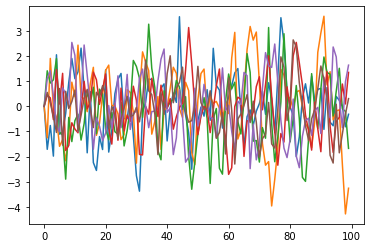

In [7]:
## Number of dimensions, number of edges, number of samples
T, n, s = 100, 6, 15

### Coefficient matrix
## First approach: A is a DAG, no model mismatch
A_true = h.generate_A(n, s, tril = False, low = 0.25, high = 0.5)

## Second approach: A is not necessarily a DAG, possible model mismatch
# A_true = (np.array([0.0] * (n ** 2 - s) + [1.0] * s) * (2 * np.random.randint(0, 2, size=(n ** 2)) - 1) * np.random.uniform(low = 0.45, high = 0.55, size = n ** 2))

# shuffle for randomness
# np.random.shuffle(A_true)

# reshape
# A_true = A_true.reshape(n, n)

# set coefficients to be positive (else oscillating which does not make sense)
for i in range(len(A_true)):
    A_true[i][i] = np.abs(A_true[i][i])

## True permutation
P_true = np.identity(n) # np.random.permutation(np.identity(n))

## Datagenerating W
W_true = P_true.T @ A_true @ P_true
print(f"True W:\n{np.round(W_true, 2)}.\n")

## Generate series
X = h.generate_var_2(T, n, A_true, P_true)
plt.plot(X);

### Possibly Save data

In [5]:
save = False

if save: 
    misc = "+-25_matrix_one_coef_mismatch"
    expl = "5 by 5 matrix with a completely LT +- 0.25, but then a twist. Upper right and lower left corner now have coefficient 0.5, resulting in one huge violator, which throws the lingnams off."
    h.save_data(X, W_true, misc, expl)

### Possibly Load data

[[ 0.37986145  0.          0.6       ]
 [-0.2528264   0.31821181  0.        ]
 [-0.6        -0.341357    0.34555248]]


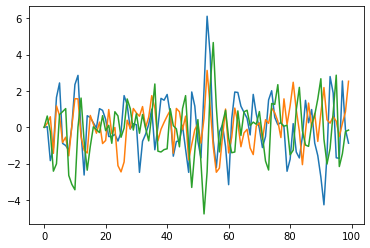

In [6]:
load = False
name = "X_s16_n100_T5_+-25_matrix_one_coef_mismatch_0"
if load:
    W_true, X, expl = h.load_data(name)
    print(f"Loaded {name}.\nExplation: {expl}.")
    
print(W_true)
plt.plot(X)

### Lasso Regularization Approach

In [8]:
W_lasso, lambda_min = m._LASSO_LINGNAM(X, 0.001)
print(f"W_lasso:\n{np.round(W_lasso, 2)}.\n")
h.score(X, W_lasso, W_true, rounding = 10);
print(lambda_min)

W_lasso:
[[ 0.08  0.    0.    0.    0.    0.  ]
 [ 0.    0.37  0.    0.   -0.1   0.  ]
 [ 0.    0.    0.21  0.    0.    0.  ]
 [-0.21 -0.2  -0.12  0.13  0.    0.  ]
 [ 0.    0.    0.08  0.    0.15  0.  ]
 [ 0.    0.32  0.08  0.   -0.11  0.  ]].

True Positive Rate: 0.8.
True Negative Rate: 0.9523809524.
False Prediction Rate: 0.0769230769
Accuracy: 0.8888888889.
R-Squared: 0.3191379147
Mean Squared Error: 7.3283376246
0.35400000000000026


### Lingnam Approach

In [9]:
W_ling, W_OLS = m._OLS_LINGNAM(X)
print(f"W_ling:\n{np.round(W_ling, 2)}.\n")
h.score(X, W_ling, W_true, rounding = 10);
print(np.round(W_OLS, 2))

W_ling:
[[ 0.28  0.    0.    0.    0.    0.  ]
 [ 0.    0.5   0.    0.   -0.16  0.  ]
 [ 0.    0.    0.36  0.    0.    0.  ]
 [-0.47 -0.48 -0.33  0.39  0.    0.  ]
 [ 0.    0.    0.36  0.    0.34  0.  ]
 [ 0.    0.67  0.4   0.   -0.41  0.36]].

True Positive Rate: 0.8666666667.
True Negative Rate: 0.9523809524.
False Prediction Rate: 0.0714285714
Accuracy: 0.9166666667.
R-Squared: 0.3688470053
Mean Squared Error: 6.1623262045
[[ 0.28 -0.12 -0.06  0.01 -0.02 -0.02]
 [ 0.02  0.5   0.1   0.05 -0.16 -0.  ]
 [-0.14 -0.08  0.36  0.09 -0.01 -0.05]
 [-0.47 -0.48 -0.33  0.39 -0.01 -0.07]
 [-0.01  0.05  0.36 -0.14  0.34  0.04]
 [ 0.06  0.67  0.4   0.13 -0.41  0.36]]


### OMP Approach

In [10]:
W_omp, edges, scores = m._OMP(X, get_order = True)
print(f"W_OMP:\n{np.round(W_omp, 2)}.\n")
h.score(X, W_omp, W_true, rounding = 10);

W_OMP:
[[ 0.28 -0.12  0.    0.    0.    0.  ]
 [ 0.    0.51  0.    0.    0.    0.  ]
 [-0.14 -0.09  0.37  0.    0.    0.  ]
 [-0.48 -0.49 -0.35  0.37  0.    0.  ]
 [-0.02  0.05  0.31 -0.18  0.4   0.  ]
 [ 0.06  0.66  0.42  0.16 -0.46  0.34]].

True Positive Rate: 1.0.
True Negative Rate: 0.7142857143.
False Prediction Rate: 0.2857142857
Accuracy: 0.8333333333.
R-Squared: 0.380326676
Mean Squared Error: 6.0538538183


### Exhaustive Approach

In [11]:
W_exh = m._Exh(X)
print(f"W_EXH:\n{np.round(W_exh, 2)}.\n")
h.score(X, W_exh, W_true, rounding = 10);

100%|███████████████████████████████████████████████████████████████████████████████| 720/720 [00:01<00:00, 388.14it/s]

W_EXH:
[[ 0.28 -0.12  0.    0.    0.    0.  ]
 [ 0.    0.5   0.    0.    0.    0.  ]
 [-0.14 -0.08  0.37  0.    0.    0.  ]
 [-0.48 -0.48 -0.35  0.37  0.    0.  ]
 [-0.02  0.05  0.31 -0.18  0.4   0.  ]
 [ 0.06  0.67  0.42  0.16 -0.46  0.34]].

True Positive Rate: 1.0.
True Negative Rate: 0.7142857143.
False Prediction Rate: 0.2857142857
Accuracy: 0.8333333333.
R-Squared: 0.3802997353
Mean Squared Error: 6.0535856236


### NOTEARS

In [14]:
threshold, step_size = 0.0, 0.001

W_notears = m._notears_2(X, loss_type="l2-var", lambda1=0.0, rho_max = 1e10, w_threshold = 0.0)

print(f"W_notears before thresholding, not necessarily a DAG:\n{np.round(W_notears, 10)}.\n")

# fix dag_ness
while not h.is_dag(W_notears):
    threshold += step_size
    W_notears[np.abs(W_notears) < threshold] = 0
    
print(f"W_notears after smallest threshold {round(threshold, 2)} such that we have a DAG:\n{np.round(W_notears, 2)}.\n")

h.score(X, W_notears, W_true, rounding = 10);

h: 3.9610988444849227e-07.
rho: 10000000000.0.
loss: (3.0418276645506483, array([ 9.46133887e-05, -2.64278752e-01, -4.98976717e-01,  1.93716993e-01,
       -1.51821060e-01, -1.22962031e-01,  2.30989061e-01,  1.69612879e-04,
        3.31102503e-01,  1.33923339e+00, -8.12378097e-02, -2.31327807e-01,
       -2.14339122e-01, -8.09255938e-01, -3.64419909e-04,  1.12361378e+00,
       -1.20913999e-01, -5.40413126e-01, -1.60831253e-04, -1.44212397e-02,
       -1.70248544e-04, -5.34499246e-04, -7.61709203e-03, -5.16846554e-01,
       -6.85235572e-02,  3.30953914e-01,  1.66155758e-02, -1.34190951e+00,
        6.64433737e-05,  4.96265096e-01,  3.20714611e-04,  4.06606907e-05,
       -3.45919533e-04,  2.01921843e-04, -7.93191974e-05,  8.38349417e-07,
       -9.46133887e-05,  2.64278752e-01,  4.98976717e-01, -1.93716993e-01,
        1.51821060e-01,  1.22962031e-01, -2.30989061e-01, -1.69612879e-04,
       -3.31102503e-01, -1.33923339e+00,  8.12378097e-02,  2.31327807e-01,
        2.14339122e-01,  8

In [23]:
threshold, step_size = 0.0, 0.001

W_notears_2 = m._notears_2(X, loss_type="l2-var", lambda1=0.0, rho_max = 1e30,  w_threshold = 0.0)

print(f"W_notears before thresholding, not necessarily a DAG:\n{np.round(W_notears_2, 10)}.\n")
    
print(f"W_notears_2 after smallest threshold {round(threshold, 2)} such that we have a DAG:\n{np.round(W_notears_2, 2)}.\n")

h.score(X, W_notears_2, W_true, rounding = 10);

h: 7.105427357601002e-15.
rho: 9.999999999999999e+30.
loss: (5305.23034011227, array([-2.17163419e-04,  5.10701080e+08,  1.76333842e+09,  8.02212815e+01,
        1.38128038e+03, -3.59113470e+07,  1.10530410e+04, -2.71088121e+03,
       -5.20327770e-05, -3.99871765e+09, -3.45308388e+01, -1.28131337e+04,
       -8.13479648e+02,  3.24312788e+03,  1.59348808e+04,  4.60444410e+03,
       -8.66578392e-04, -7.74457783e+02, -6.79337589e+04,  2.41403050e+03,
       -9.86281711e+03,  2.52663509e+09, -4.57969428e+08,  1.49434512e+09,
       -1.09759481e-06,  8.15832474e+08, -4.04467211e+08, -2.47743281e+08,
        1.29129446e+09, -2.73270815e+08,  6.15335098e+09, -2.75677542e+01,
        2.29811690e-03,  2.21377171e+08, -9.60151585e+08, -1.19773125e+02,
        1.60963796e+09, -1.33211182e+09,  4.31198274e+01,  3.86307811e+03,
       -1.61370104e-05,  5.00567527e+01, -9.65155282e+09,  4.68050230e+09,
       -6.30809877e+09, -3.02700424e+02, -1.41093456e+04,  2.78594293e+08,
        6.37195356e-0

### Conclusions:
When there is *no* model mismatch, all methods seem to perform quite well, as there are no "hard decisions" to be made. "Untrue" parameters that were estimated to be e.g. 0.04 due to randomness are easily distinguished from the true parameters, which were estimated to be e.g. 0.40. 

However, when there *is* a model mismatch, the lingnam-OLS and lingnam-LASSO perform very poorly. This is because they cannot make the "hard decision" between choosing between $w(i, j)$ or $w(j, i)$. When such a choice needs to be made, all other coefficients that are smaller in absolute value than $\min(w(i, j), w(j, i))$ will have to be filtered out first. All other coefficients will suffer using the lingnam approaches when we have a hard decision with two conflicting $w(i, j)$ and $w(j, i)$ with large coefficients.